## Обработка изображений. Задание 2

__Володин Сергей__, группа 374

Цель работы: классификация геоглифов пустыни Наска.

 * Вход: изображения геоглифов (BMP)
 * Число классов: 7

Типы геоглифов:
 * Схематичный, неискаженный
 * Схематичный, искаженный
 * Фото со спутника

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import skimage
from skimage import io, morphology, segmentation
from pandas import DataFrame as df
from scipy.ndimage.morphology import binary_fill_holes
from joblib import Parallel, delayed
import multiprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from __future__ import print_function
from skimage.transform import rescale, resize, downscale_local_mean
from tqdm import tqdm

## Параметры

In [2]:
# Количество итераций для очистки скелета
prune_skeleton_n = 3

# Порог
image_thresold = 150

# Не добавлять пересечение, если уже есть пересечение на таком расстоянии
intersection_thresold = 3

np.warnings.filterwarnings('ignore')

In [3]:
def display_single(im):
    plt.figure(figsize=(10,10))
    plt.imshow(im > 0, interpolation = 'nearest', cmap = 'gray')
    plt.show()

## Загрузка изображений

In [4]:
# Загрузка изображений
imc = skimage.io.imread_collection("Geogliph_1/*")

## Метки классов
Имеются 7 классов, по 4 объекта в каждом

In [5]:
# Заполнение меток
num_per_class = 4
N = len(imc.files)
y = np.zeros((N, ), dtype = np.int32)
for i in range(N):
    y[i] = i / num_per_class
n_classes = np.max(y) + 1

## Функции для работы с геоглифами

 * Бинаризация с порогом
 * Скелетонизация методом skeletonize_3d (T.-C. Lee, R.L. Kashyap and C.-N. Chu, Building skeleton models via 3-D medial surface/axis thinning algorithms. Computer Vision, Graphics, and Image Processing, 56(6):462-478, 1994)

In [6]:
def binarize(im):
    ''' Бинаризация изображения '''
    # Среднее по всем каналам
    im_gray = np.average(im, axis = 2)
    
    # Бинаризация
    im_bin = 1. * (im_gray < image_thresold)
    
    # Заполняем "дыры"
    im_bin = binary_fill_holes(im_bin)
    
    # Убираем маленькие объекты
    im_bin = skimage.morphology.remove_small_objects(im_bin > 0, 20)
    
    # Обрезаем изображение
    add = 10
    bound = np.where(im_bin > 0)
    im_bin = im_bin[max(0, np.min(bound[0]) - add):min(im_bin.shape[0], np.max(bound[0]) + add + 1), max(0, np.min(bound[1]) - add):min(im_bin.shape[1], np.max(bound[1]) + add + 1)]
    return(im_bin)

def skeletonize(im_bin):
    ''' Скелетонизация '''
    
    im_sk = 1 * (skimage.morphology.skeletonize_3d(im_bin) > 0)
    
    return(im_sk)

Подсчет соседей для данного пиксела (квадратная матрица порядка 2step + 1)

In [7]:
def neighbours(im, i, j, step = 1):
    ''' Соседи для данного пиксела '''
    (x, y) = im.shape
    return im[max(0, i - step):min(i + step + 1, x),max(0, j - step):min(j + step + 1, y)]

def count_neighbours(im):
    ''' Подсчитать количество соседей для каждого пиксела  '''
    res = np.zeros(9)
    
    neighbours_arr = np.zeros(im.shape)
    
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i][j] > 0:
                neighbours_arr[i][j] = int(max(np.sum(neighbours(im, i, j)) - 1, 0))

    return neighbours_arr

* Число листов (количество соседей = 1)
* Число пересечений (количество соседей > 2), удаляем слишком близкие пересечения

In [8]:
def get_leaves(n_arr):
    ''' Вернуть листовые пикселы '''
    mask = 1. * (n_arr == 1)
    return np.sum(mask), mask

def get_intersections(n_arr):
    ''' Вернуть пикселы, соответствующие пересечениям в скелете '''
    mask = 1. * (n_arr > 2)
    result = np.zeros(n_arr.shape)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] and np.sum(neighbours(result, i, j, intersection_thresold)) == 0:
                result[i][j] = 1
    return np.sum(result), result

Прореживание: удаление концевых точек

In [9]:
def prune_skeleton(im_sk, size = 0):
    ''' Прореживание скелета: удаление коротких отростков '''
    im_sk = 1 * (im_sk > 0)
    for i in range(size):
        _, endpoints = get_leaves(count_neighbours(im_sk))
        endpoints = np.logical_not(endpoints)
        im_sk = np.logical_and(im_sk, endpoints)
    return 1. * im_sk

Визуализация скелета

Цвета: 
 * Синий --- скелет
 * Зеленый --- пересечения
 * Красный --- листовые вершины

In [10]:
def construct_preview(im_sk, m_l, m_i):
    ''' Визуализация скелета (синий) с листовыми вершинами (красные) и пересечениями (зеленые) '''
    res = np.zeros((im_sk.shape[0], im_sk.shape[1], 3))
    res[:, :, 2] = im_sk * 1.
    res[:, :, 0] = m_l * 1.
    res[:, :, 1] = m_i * 1.
    return res

Обработка одного изображения: применение всех функций выше последовательно

In [11]:
def process_image(im):
    ''' Бинаризация, построение скелета, визуализация, подсчет признаков '''
    im_bin = binarize(im)
    im_sk = skeletonize(im_bin)
    im_sk = prune_skeleton(im_sk, prune_skeleton_n)
    n_arr = count_neighbours(im_sk)
    c_c = np.max(skimage.morphology.label(im_bin))
    c_l, m_l = get_leaves(n_arr)
    c_i, m_i = get_intersections(n_arr)
    preview = 2 * (construct_preview(im_sk, m_l, m_i) - 0.5)
    return {'f_leaves': c_l, 'f_intersections': c_i, 'f_connectivity': c_c, 'im_bin': im_bin, 'im_sk': im_sk, 'preview': preview}

Функция для параллельной обработки коллекции

In [12]:
def process_shot(i):
    ''' Получить признаки для индекса i в коллекции '''
    res = process_image(imc[i])
    return res
def process_collection(idx = None):
    ''' Обработка коллекции на всех процессорах '''
    if idx == None:
        idx = range(len(imc.files))
    num_cores = multiprocessing.cpu_count()
    res = Parallel(n_jobs = num_cores)(delayed(process_shot)(i) for i in idx)
    return res

## Обработка коллекции

In [13]:
res = process_collection()

## Расстояние между объектами одного класса

In [14]:
features = ['f_leaves', 'f_intersections']
r = [0] * n_classes
for i in range(n_classes):
    idx_class = np.where(y == i)[0]
    r[i] = {}
    for f in features:
        r[i][f] = []
    for j1 in idx_class:
        for j2 in idx_class:
            for f in features:
                if j1 < j2:
                    r[i][f].append(abs(res[j1][f] - res[j2][f]))

In [15]:
for i in range(n_classes):
    for f in features:
        rr = r[i][f]
        print("Class {}\t{}:\tMin {} Mean {} Max {}".format(i, f[:10], round(np.min(rr), 2), round(np.mean(rr), 0), np.max(rr)))

Class 0	f_leaves:	Min 0.0 Mean 0.0 Max 0.0
Class 0	f_intersec:	Min 0.0 Mean 1.0 Max 1.0
Class 1	f_leaves:	Min 0.0 Mean 1.0 Max 1.0
Class 1	f_intersec:	Min 0.0 Mean 1.0 Max 2.0
Class 2	f_leaves:	Min 1.0 Mean 3.0 Max 6.0
Class 2	f_intersec:	Min 0.0 Mean 3.0 Max 6.0
Class 3	f_leaves:	Min 0.0 Mean 2.0 Max 4.0
Class 3	f_intersec:	Min 1.0 Mean 4.0 Max 7.0
Class 4	f_leaves:	Min 0.0 Mean 1.0 Max 2.0
Class 4	f_intersec:	Min 0.0 Mean 1.0 Max 2.0
Class 5	f_leaves:	Min 0.0 Mean 1.0 Max 2.0
Class 5	f_intersec:	Min 0.0 Mean 1.0 Max 2.0
Class 6	f_leaves:	Min 0.0 Mean 4.0 Max 8.0
Class 6	f_intersec:	Min 0.0 Mean 7.0 Max 11.0


## Построение визуализации для класса

In [16]:
class_visual = 0
idx_visual = np.where(y == class_visual)[0]
res_visual = []
for i in idx_visual:
    res_visual.append(res[i])
#res_visual = process_collection(idx_visual)
N_visual = len(idx_visual)

In [17]:
for i in range(N_visual):
    print(idx_visual[i], res_visual[i]['f_leaves'], res_visual[i]['f_intersections'], res_visual[i]['im_bin'].shape)

0 18.0 14.0 (297, 291)
1 18.0 13.0 (282, 317)
2 18.0 14.0 (386, 279)
3 18.0 13.0 (290, 278)


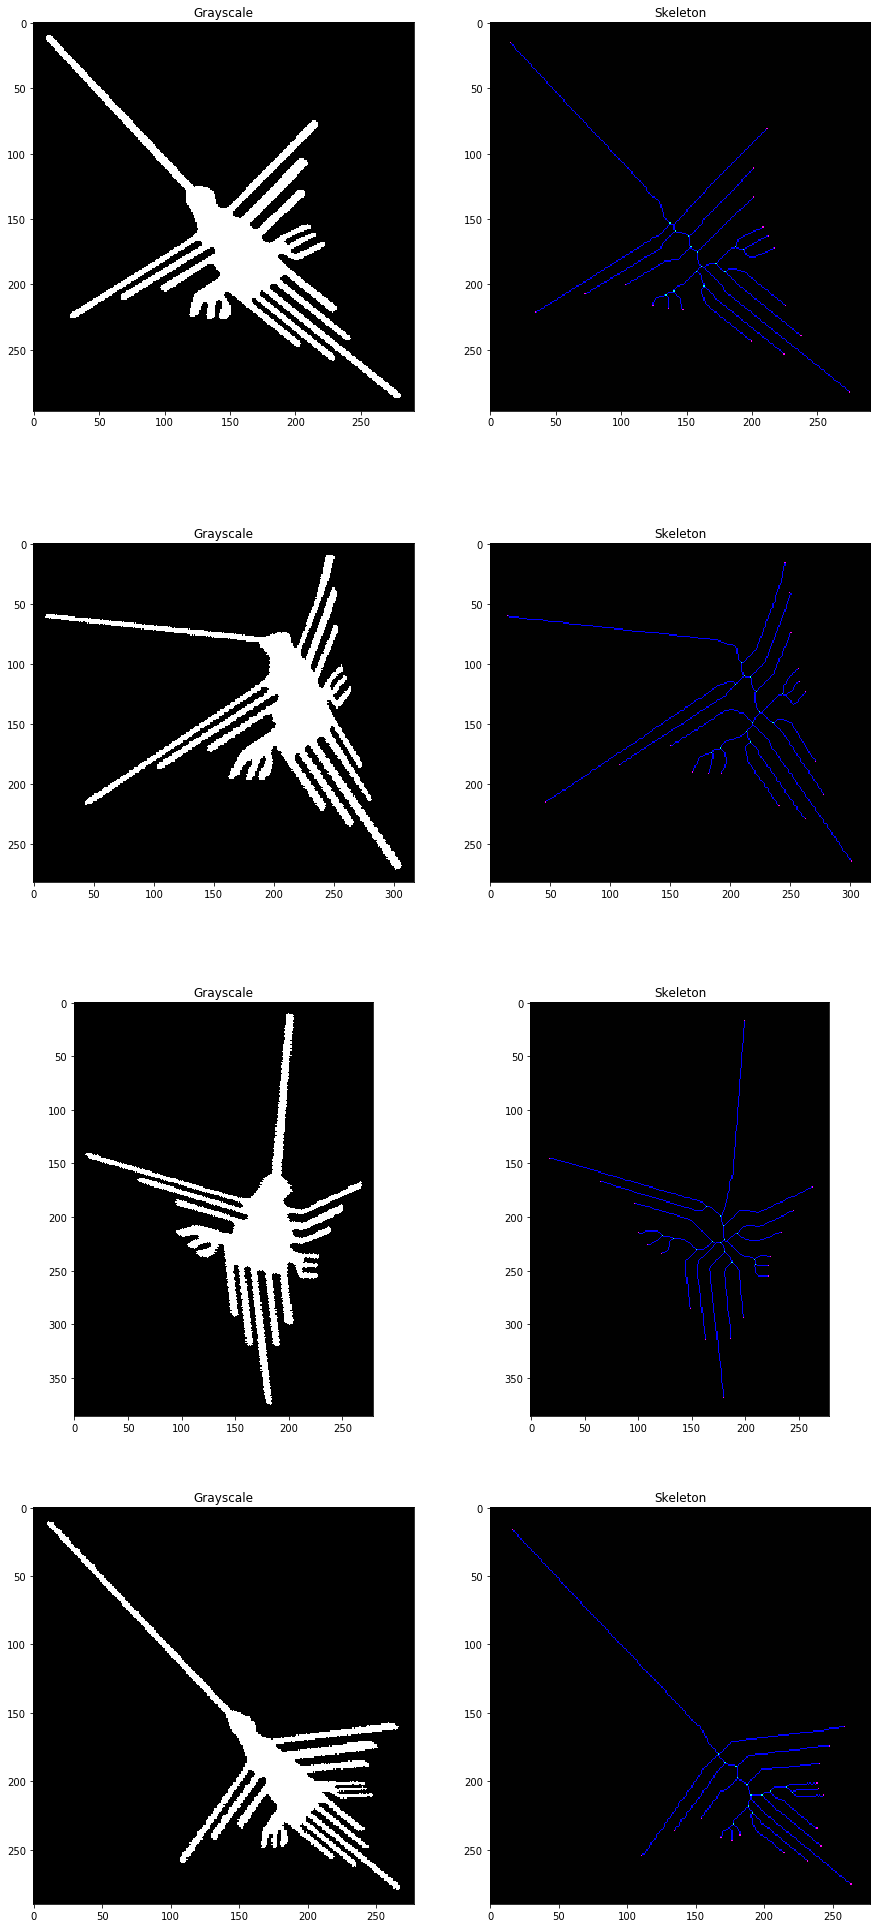

In [18]:
f, axarr = plt.subplots(N_visual, 2, figsize=(15,35))
for i in range(len(idx_visual)):
    axarr[i, 0].imshow(res_visual[i]['im_bin'], cmap = 'gray', interpolation = 'nearest')
    axarr[i, 0].set_title('Grayscale')
    axarr[i, 1].imshow(res_visual[i]['preview'], interpolation = 'nearest')
    axarr[i, 1].set_title('Skeleton')

## Получение признаков

In [19]:
def res_to_features(res):
    N = len(res)
    X = np.zeros((N, 2))
    for i in range(N):
        X[i,0] = res[i]['f_leaves']
        X[i,1] = res[i]['f_intersections']
        #X[i,2] = res[i]['f_connectivity']
    return X
X = res_to_features(res)

In [20]:
cmap = plt.cm.get_cmap('gnuplot')
def plot_features(features, labels, marker = '.'):
    ''' Распределение признаков и одинаковые классы '''
    plt.scatter(features[:,0], features[:,1], c = labels, cmap = cmap, marker = marker, alpha = 1)
def plot_title():
    plt.title('Feature distribution')
    plt.xlabel('Leaves')
    plt.ylabel('Intersections')
def plot_lines(features, labels):
    N = features.shape[0]
    for i in range(N):
        p1 = (features[i,0], features[i,1])
        plt.text(p1[0], p1[1], labels[i])
        for j in range(N):
            p2 = (features[j,0], features[j,1])
            if labels[i] == labels[j]:
                plt.plot((p1[0], p2[0]), (p1[1], p2[1]), color='black' , alpha = 0.05)

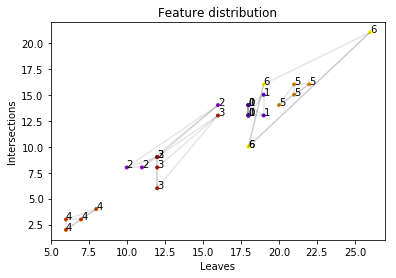

In [21]:
plot_features(X, y)
plot_lines(X, y)
plot_title()

## Построение классификатора
Используется решающее дерево

In [22]:
#plot_features(X, y)
def plot_dec_function(X, clf):
    plot_step = 1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap = cmap, alpha = 0.3)

train_idx: [ 1  2  3  4  5  7  8 10 11 12 13 14 16 17 19 20 21 23 24 26 27]
test_idx : [ 0  6  9 15 18 22 25]
test accuracy: 0.714285714286



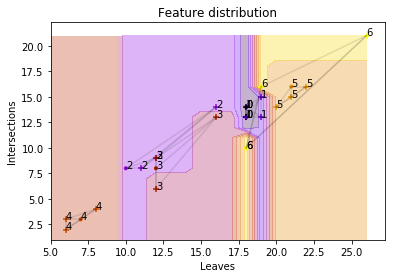

train_idx: [ 0  2  3  5  6  7  8  9 11 13 14 15 17 18 19 21 22 23 24 25 26]
test_idx : [ 1  4 10 12 16 20 27]
test accuracy: 0.571428571429



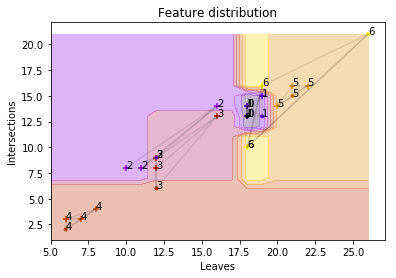

train_idx: [ 0  1  2  4  5  6  9 10 11 12 13 15 16 18 19 20 22 23 24 25 27]
test_idx : [ 3  7  8 14 17 21 26]
test accuracy: 0.571428571429



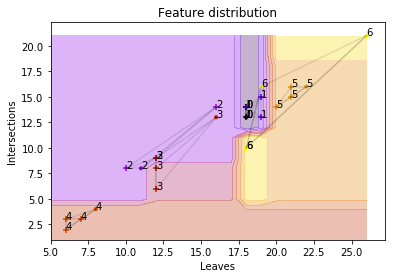

train_idx: [ 0  1  3  4  6  7  8  9 10 12 14 15 16 17 18 20 21 22 25 26 27]
test_idx : [ 2  5 11 13 19 23 24]
test accuracy: 0.428571428571



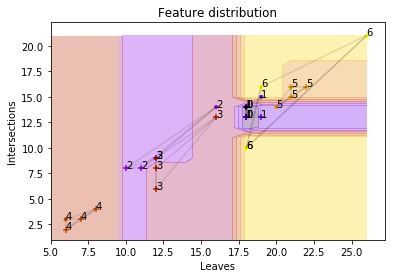

In [23]:
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 4)
skf.get_n_splits(X, y)
accuracy = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    accuracy.append(acc)
    
    plot_dec_function(X, clf)
    plot_features(X_train, y_train, '+')
    plot_features(X_test, y_test, '.')
    plot_lines(X, y)
    plot_title()
    print("train_idx: {}\ntest_idx : {}\ntest accuracy: {}\n".format(train_index, test_index, acc))
    plt.show()

In [24]:
print("Accuracy: {}\nMean accuracy: {}\nWorst accuracy: {}".format(accuracy, np.mean(accuracy), 1. / n_classes))

Accuracy: [0.7142857142857143, 0.5714285714285714, 0.5714285714285714, 0.42857142857142855]
Mean accuracy: 0.571428571429
Worst accuracy: 0.142857142857


## Построение финального классификатора и тестирование

Accuracy: 0.892857142857


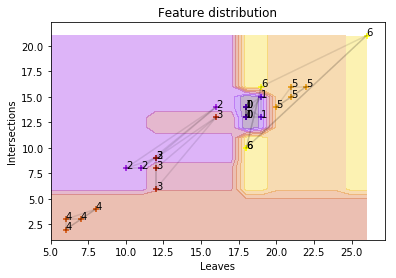

In [25]:
clf = clf.fit(X, y)
y_pred = clf.predict(X)
acc = accuracy_score(y_pred, y)
print("Accuracy: {}".format(acc))
plot_dec_function(X, clf)
plot_features(X, y, '+')
plot_lines(X, y)
plot_title()

## Загрузка новой коллекции

In [40]:
test_filename = u'Geogliph_1/Силуэт_1.bmp'

def get_class(filename):
    # Загрузка изображения
    im = skimage.io.imread(u'Geogliph_1/Силуэт_2.bmp')

    # Получение признаков
    res_test = process_image(im)
    X_test = res_to_features([res_test])

    # Предсказания
    y_pred = clf.predict(X_test)[0]
    
    return y_pred, im

test_answer, test_im = get_class(test_filename)

Test name Geogliph_1/Силуэт_1.bmp Predicted class 1


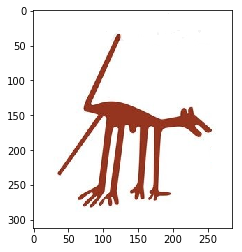

In [41]:
print(u"Test name {} Predicted class {}".format(test_filename, test_answer))
plt.imshow(test_im)
plt.show()